In [1]:
### Mining restaurant order
import numpy as np 
import pandas as pd  # process data 
import matplotlib
import matplotlib.pyplot as plt #
import seaborn as sns  # statistical plotting
from sklearn.preprocessing import LabelEncoder, Imputer, OneHotEncoder, StandardScaler # Preprocessing

from sklearn.model_selection import KFold, cross_val_score, train_test_split, learning_curve, validation_curve, GridSearchCV  # Model 
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor 
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor  # Ensemble methods
from sklearn.svm import SVR  # 
from sklearn.tree import DecisionTreeRegressor # 
from sklearn.pipeline import Pipeline 
## reduce dimension
from sklearn.decomposition import KernelPCA, PCA #
from sklearn.feature_selection import SelectFromModel 

from sklearn.base import clone 
from sklearn.metrics import mean_squared_error as MSE

# Data Cleaning
#### This is meant not to be a model using common classification, so the data cleaning will be a bit different (but more or less the same), this time use the first csv first.

In [2]:
bills_df = pd.read_csv('D:/Project_Restaurant_Chain/Full/big_bills.csv')

In [3]:
bills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5152404 entries, 0 to 5152403
Data columns (total 18 columns):
Unnamed: 0               int64
branch_number            int64
concept_number           int64
revenue_centre_number    int64
brand                    object
sale_date                object
guest_check_number       int64
check_datetimestart      object
check_datetimestop       object
total_covers             int64
total_gross_sales        float64
total_net_sales          float64
total_service_charge     float64
total_tip                float64
total_discount           float64
total_cost               float64
total_stock_cost         float64
total_tesco_rebate       float64
dtypes: float64(8), int64(6), object(4)
memory usage: 707.6+ MB


In [3]:
check_time_difference_in_minutes_df = pd.read_csv('D:/Project_Restaurant_Chain/Full/check_time_difference_in_minutes.csv')

In [4]:
check_time_difference_in_minutes_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
bills_df = bills_df.join(check_time_difference_in_minutes_df)

In [7]:
bills_df.columns

Index(['Unnamed: 0', 'branch_number', 'concept_number',
       'revenue_centre_number', 'brand', 'sale_date', 'guest_check_number',
       'check_datetimestart', 'check_datetimestop', 'total_covers',
       'total_gross_sales', 'total_net_sales', 'total_service_charge',
       'total_tip', 'total_discount', 'total_cost', 'total_stock_cost',
       'total_tesco_rebate', 'check_time_difference_in_seconds'],
      dtype='object')

In [6]:
bills_df = bills_df.drop(['check_datetimestop', 'check_datetimestart'], axis=1)

In [9]:
# show basic statistics
bills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5152404 entries, 0 to 5152403
Data columns (total 17 columns):
Unnamed: 0                          int64
branch_number                       int64
concept_number                      int64
revenue_centre_number               int64
brand                               object
sale_date                           object
guest_check_number                  int64
total_covers                        int64
total_gross_sales                   float64
total_net_sales                     float64
total_service_charge                float64
total_tip                           float64
total_discount                      float64
total_cost                          float64
total_stock_cost                    float64
total_tesco_rebate                  float64
check_time_difference_in_seconds    float64
dtypes: float64(9), int64(6), object(2)
memory usage: 668.3+ MB


In [7]:
bills_df = bills_df.drop(['Unnamed: 0', 'brand', 'sale_date', 'guest_check_number'], axis = 1)

D:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['DejaVu Sans'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


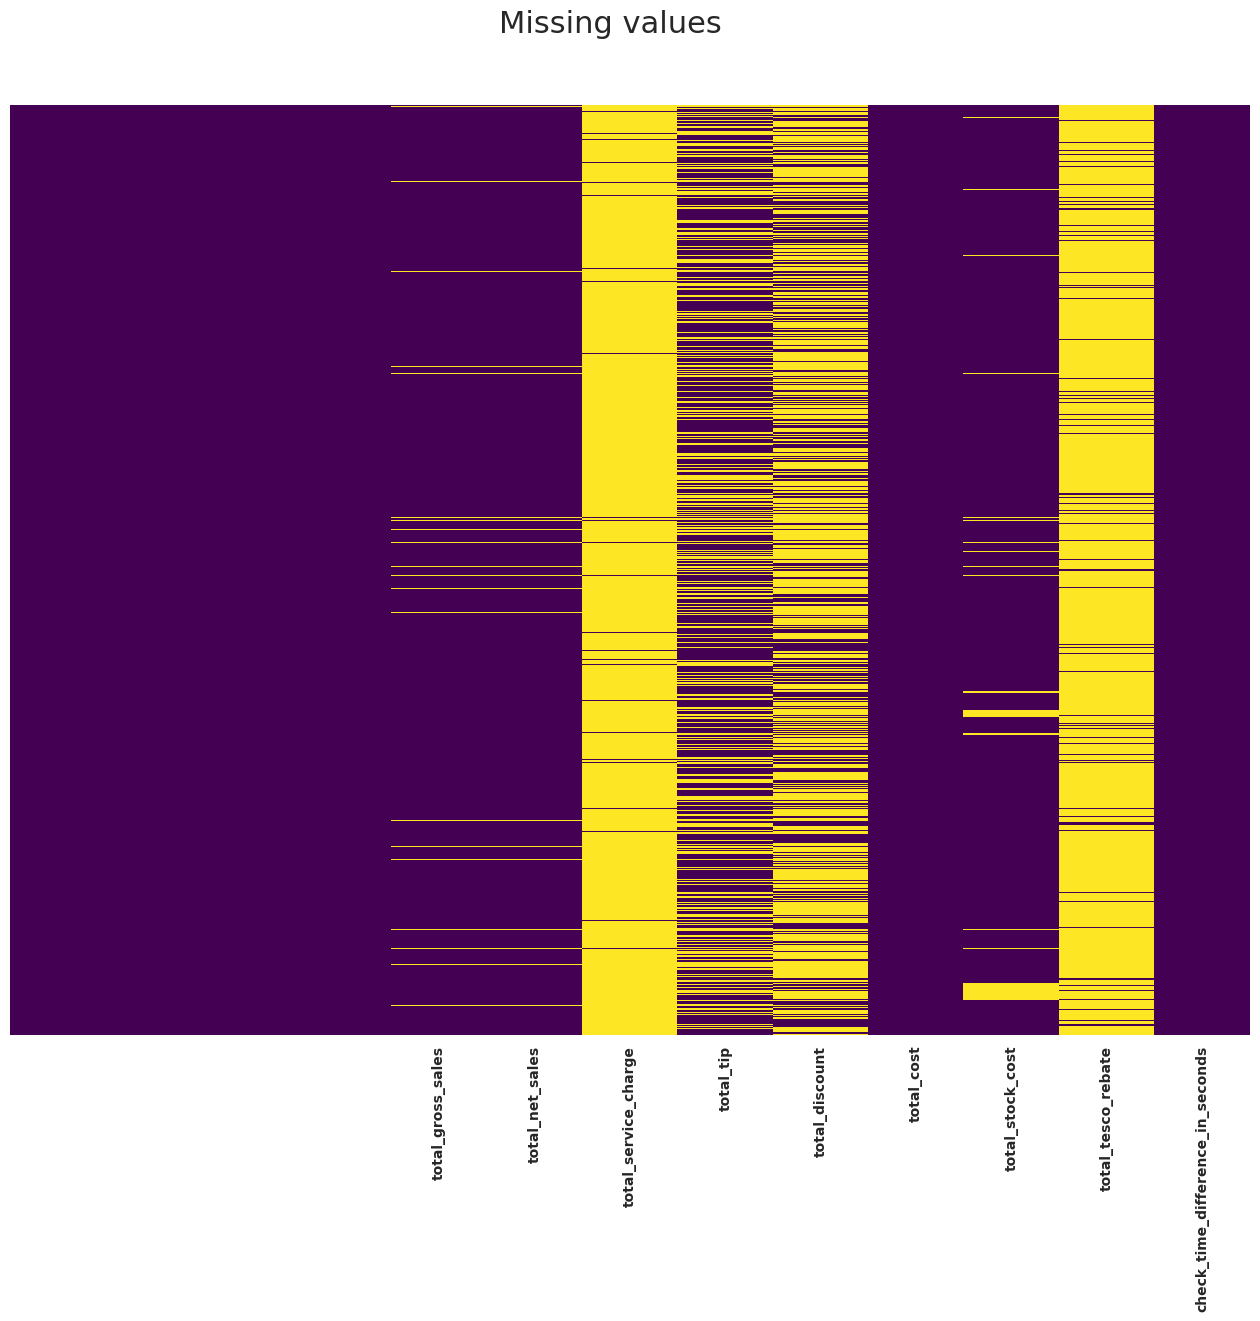

In [16]:
## check missing values
label_missed = []
for c in bills_df.columns.tolist():
    label_missed.append(c if np.sum(bills_df[c].isnull()) != 0 else "")
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22 }
matplotlib.rc('font', **font)
plt.figure(figsize=(16,12))
# distributions of missing values
sns.heatmap(bills_df.isnull(), yticklabels=False, xticklabels=label_missed, cbar=False, cmap='viridis')
plt.suptitle("Missing values")

plt.show()

It seems that there are 8 variables including missing values, and five of them may contain too many NAs: `total_service_charge`, `total_tip`, `total_discount`, `total_stock_cost`, and `total_tesco_rebate`. The other three have less missing values, we can fill them with mean values.

### From this moment on, continue using the features I think of significance.

In [13]:
features_and_covers =['total_gross_sales', 'total_tip', 'total_discount',\
       'total_cost', 'total_stock_cost', 'total_seats', 'total_inside_seats',\
       'ground_seats', '1st_floor_seats', 'bar_seats', 'outside_seats',\
       'private_dining_covers', 'check_time_difference_in_seconds', 'total_covers']

In [9]:
merged_df = pd.read_csv('D:/Project_Restaurant_Chain/Full/merged_dataset.csv')

In [14]:
selected_df = merged_df[features_and_covers]

Delete nagetive covers from the dataset.

In [15]:
selected_df = selected_df[selected_df.total_covers>=0]

In [32]:
skewness = selected_df.skew()
skewness

total_gross_sales                   3.811314
total_tip                           5.550112
total_discount                     -5.067120
total_cost                         -4.527498
total_stock_cost                    4.707093
total_seats                        -0.591583
total_inside_seats                 -0.951580
ground_seats                       -0.014984
1st_floor_seats                     2.703510
bar_seats                           5.832103
outside_seats                       0.736569
private_dining_covers               3.822035
check_time_difference_in_seconds    4.771352
total_covers                        2.649409
dtype: float64

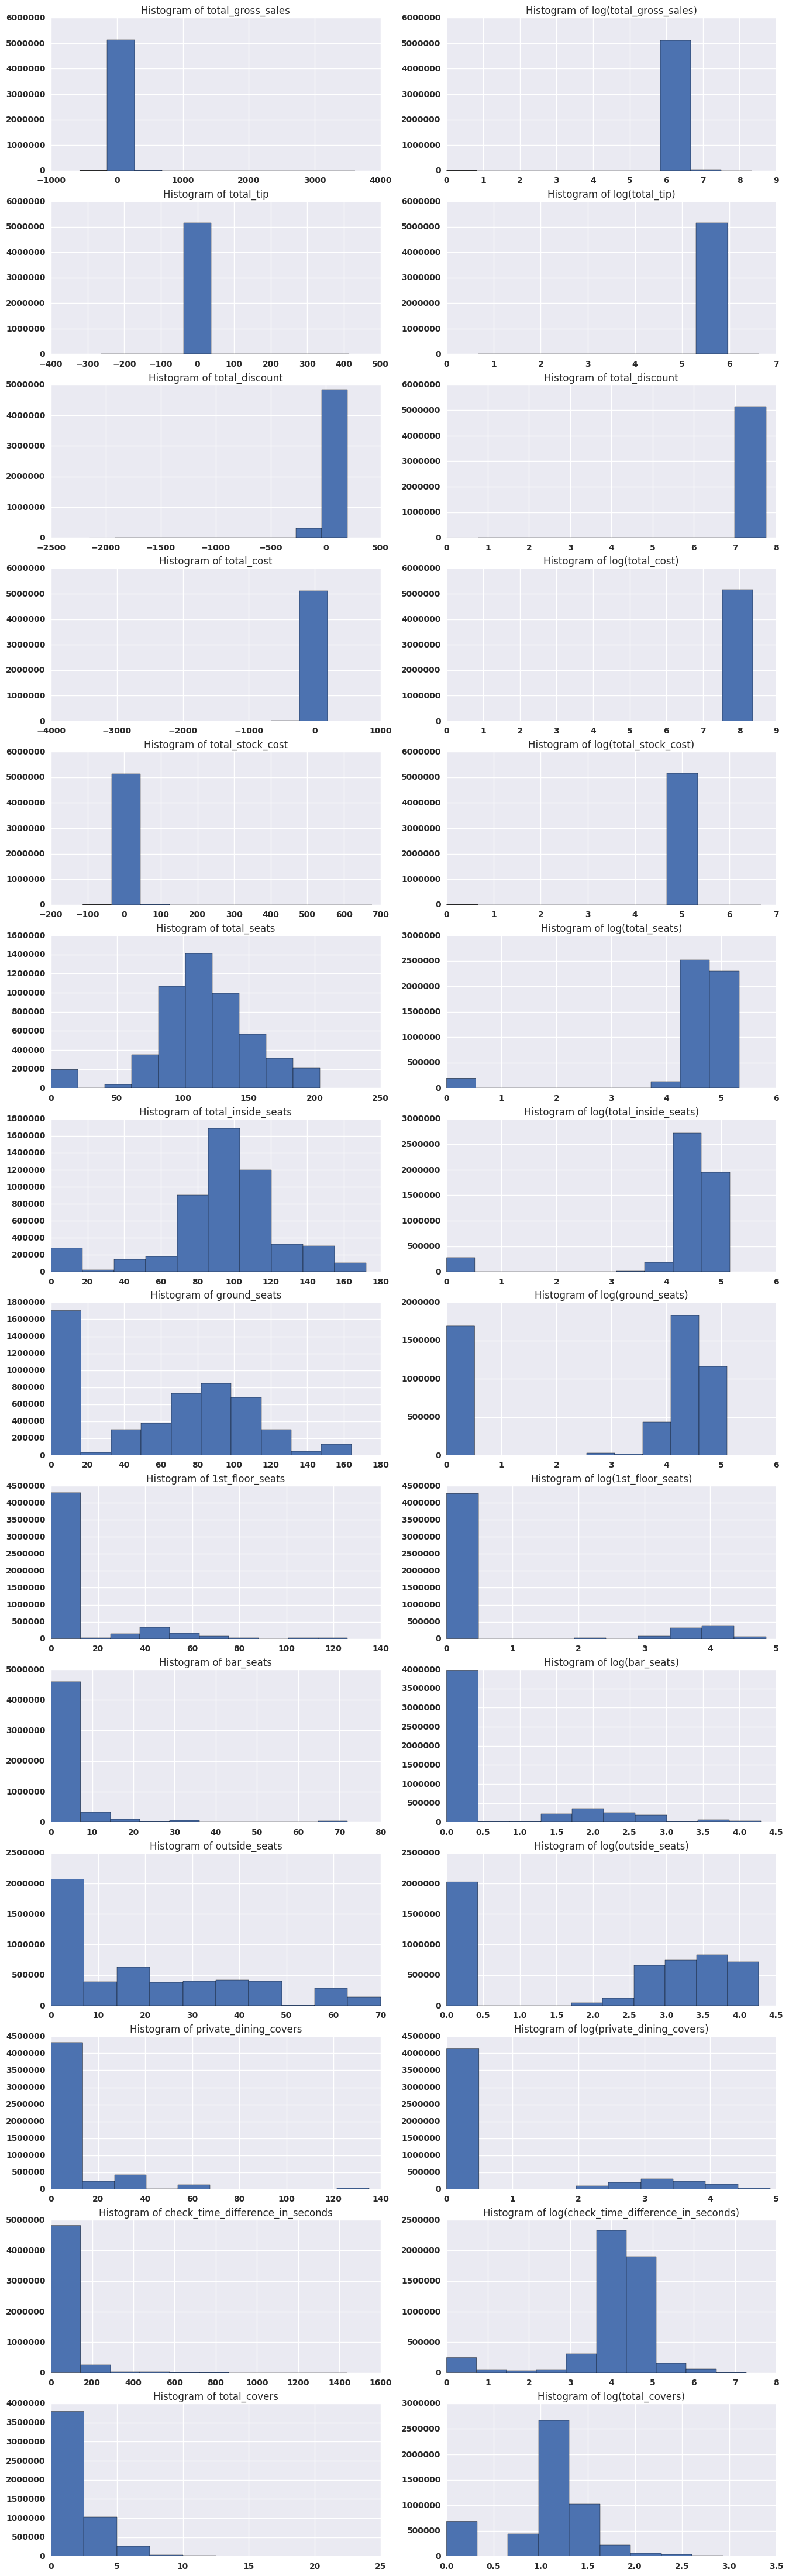

In [37]:
fig = plt.figure(figsize=(16,56))

ax1 = fig.add_subplot(14,2,1)
selected_df['total_gross_sales'].hist()
ax1.title.set_text('Histogram of total_gross_sales')
ax2 = fig.add_subplot(14,2,2) 
ax2.hist(np.log(1+selected_df['total_gross_sales'] + np.abs(selected_df['total_gross_sales'].min())))
ax2.title.set_text('Histogram of log(total_gross_sales)')

ax3 = fig.add_subplot(14,2,3)
selected_df['total_tip'].hist()
ax3.title.set_text('Histogram of total_tip')
ax4 = fig.add_subplot(14,2,4)
ax4.hist(np.log(1+selected_df['total_tip'] + np.abs(selected_df['total_tip'].min())))
ax4.title.set_text('Histogram of log(total_tip)')

ax5 = fig.add_subplot(14,2,5)
selected_df['total_discount'].hist()
ax5.title.set_text('Histogram of total_discount')
ax6 = fig.add_subplot(14,2,6)
ax6.hist(np.log(1+selected_df['total_discount'] + np.abs(selected_df['total_discount'].min())))
ax6.title.set_text('Histogram of total_discount')

ax7 = fig.add_subplot(14,2,7)
selected_df['total_cost'].hist()
ax7.title.set_text('Histogram of total_cost')
ax8 = fig.add_subplot(14,2,8)
ax8.hist(np.log(1+selected_df['total_cost'] + np.abs(selected_df['total_cost'].min())))
ax8.title.set_text('Histogram of log(total_cost)')

ax9 = fig.add_subplot(14,2,9)
selected_df['total_stock_cost'].hist()
ax9.title.set_text('Histogram of total_stock_cost')
ax10 = fig.add_subplot(14,2,10)
ax10.hist(np.log(1+selected_df['total_stock_cost'] + np.abs(selected_df['total_stock_cost'].min())))
ax10.title.set_text('Histogram of log(total_stock_cost)')

ax11 = fig.add_subplot(14,2,11)
selected_df['total_seats'].hist()
ax11.title.set_text('Histogram of total_seats')
ax12 = fig.add_subplot(14,2,12)
ax12.hist(np.log(1+selected_df['total_seats'] + np.abs(selected_df['total_seats'].min())))
ax12.title.set_text('Histogram of log(total_seats)')

ax13 = fig.add_subplot(14,2,13)
selected_df['total_inside_seats'].hist()
ax13.title.set_text('Histogram of total_inside_seats')
ax14 = fig.add_subplot(14,2,14)
ax14.hist(np.log(1+selected_df['total_inside_seats'] + np.abs(selected_df['total_inside_seats'].min())))
ax14.title.set_text('Histogram of log(total_inside_seats)')

ax15 = fig.add_subplot(14,2,15)
selected_df['ground_seats'].hist()
ax15.title.set_text('Histogram of ground_seats')
ax16 = fig.add_subplot(14,2,16)
ax16.hist(np.log(1+selected_df['ground_seats'] + np.abs(selected_df['ground_seats'].min())))
ax16.title.set_text('Histogram of log(ground_seats)')

ax17 = fig.add_subplot(14,2,17)
selected_df['1st_floor_seats'].hist()
ax17.title.set_text('Histogram of 1st_floor_seats')
ax18 = fig.add_subplot(14,2,18)
ax18.hist(np.log(1+selected_df['1st_floor_seats'] + np.abs(selected_df['1st_floor_seats'].min())))
ax18.title.set_text('Histogram of log(1st_floor_seats)')

ax19 = fig.add_subplot(14,2,19)
selected_df['bar_seats'].hist()
ax19.title.set_text('Histogram of bar_seats')
ax20 = fig.add_subplot(14,2,20)
ax20.hist(np.log(1+selected_df['bar_seats'] + np.abs(selected_df['bar_seats'].min())))
ax20.title.set_text('Histogram of log(bar_seats)')

ax21 = fig.add_subplot(14,2,21)
selected_df['outside_seats'].hist()
ax21.title.set_text('Histogram of outside_seats')
ax22 = fig.add_subplot(14,2,22)
ax22.hist(np.log(1+selected_df['outside_seats'] + np.abs(selected_df['outside_seats'].min())))
ax22.title.set_text('Histogram of log(outside_seats)')

ax23 = fig.add_subplot(14,2,23)
selected_df['private_dining_covers'].hist()
ax23.title.set_text('Histogram of private_dining_covers')
ax24 = fig.add_subplot(14,2,24)
ax24.hist(np.log(1+selected_df['private_dining_covers'] + np.abs(selected_df['private_dining_covers'].min())))
ax24.title.set_text('Histogram of log(private_dining_covers)')

ax25 = fig.add_subplot(14,2,25)
selected_df['check_time_difference_in_seconds'].hist()
ax25.title.set_text('Histogram of check_time_difference_in_seconds')
ax26 = fig.add_subplot(14,2,26)
ax26.hist(np.log(1+selected_df['check_time_difference_in_seconds'] + np.abs(selected_df['check_time_difference_in_seconds'].min())))
ax26.title.set_text('Histogram of log(check_time_difference_in_seconds)')

ax27 = fig.add_subplot(14,2,27)
selected_df['total_covers'].hist()
ax27.title.set_text('Histogram of total_covers')
ax28 = fig.add_subplot(14,2,28)
ax28.hist(np.log(1+selected_df['total_covers'] + np.abs(selected_df['total_covers'].min())))
ax28.title.set_text('Histogram of log(total_covers)')

plt.show()

It seems that distributions of most variables are highly skewed.

In [16]:
## log transform
log_df = selected_df.copy()
log_df['total_gross_sales'] = np.log(1+selected_df['total_gross_sales'] + np.abs(selected_df['total_gross_sales'].min()))
log_df['total_tip'] = np.log(1+selected_df['total_tip'] + np.abs(selected_df['total_tip'].min()))
log_df['total_discount'] = np.log(1+selected_df['total_discount'] + np.abs(selected_df['total_discount'].min()))
log_df['total_cost'] = np.log(1+selected_df['total_cost'] + np.abs(selected_df['total_cost'].min()))
log_df['total_stock_cost'] = np.log(1+selected_df['total_stock_cost'] + np.abs(selected_df['total_stock_cost'].min()))
log_df['total_seats'] = np.log(1+selected_df['total_seats'] + np.abs(selected_df['total_seats'].min()))
log_df['total_inside_seats'] = np.log(1+selected_df['total_inside_seats'] + np.abs(selected_df['total_inside_seats'].min()))
log_df['ground_seats'] = np.log(1+selected_df['ground_seats'] + np.abs(selected_df['ground_seats'].min()))
log_df['1st_floor_seats'] = np.log(1+selected_df['1st_floor_seats'] + np.abs(selected_df['1st_floor_seats'].min()))
log_df['bar_seats'] = np.log(1+selected_df['bar_seats'] + np.abs(selected_df['bar_seats'].min()))
log_df['outside_seats'] = np.log(1+selected_df['outside_seats'] + np.abs(selected_df['outside_seats'].min()))
log_df['private_dining_covers'] = np.log(1+selected_df['private_dining_covers'] + np.abs(selected_df['private_dining_covers'].min()))
log_df['check_time_difference_in_seconds'] = np.log(1+selected_df['check_time_difference_in_seconds'] + np.abs(selected_df['check_time_difference_in_seconds'].min()))
log_df['total_covers'] = np.log(1+selected_df['total_covers'] + np.abs(selected_df['total_covers'].min()))


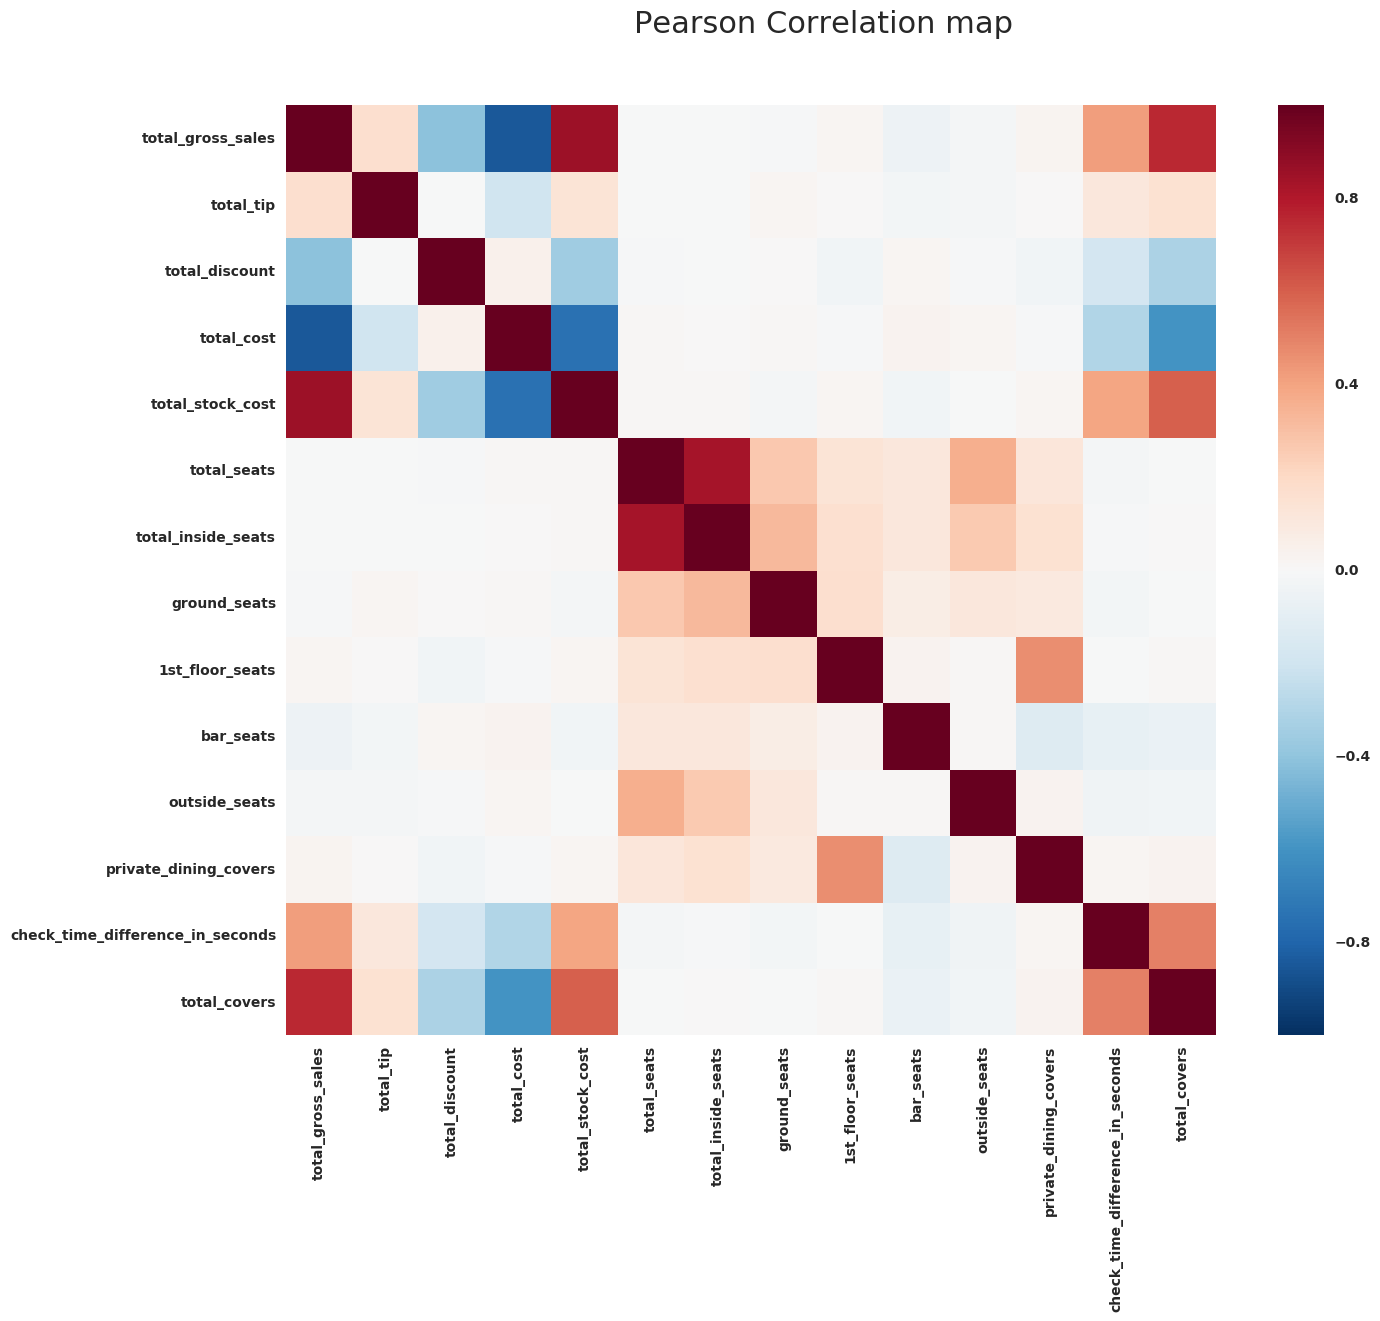

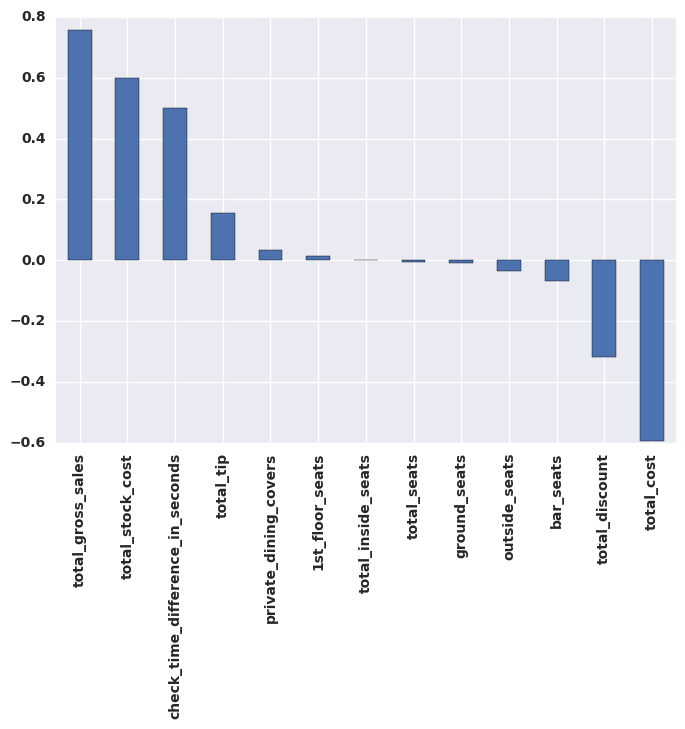

In [44]:
### correlation
pd.set_option('precision', 2)
plt.figure(figsize=(16, 12))
sns.heatmap(log_df.corr(), square = True)
plt.suptitle('Pearson Correlation map')
plt.show()

# correlation between 'total_covers' and different features
cor_with_totalcover = log_df.corr()['total_covers'].sort_values(ascending=False)
cor_with_totalcover.drop('total_covers').plot.bar()
plt.show()

Delete four features that are not correlated with 'total_covers'.

In [17]:
## drop one of collinear variables.
log_df = log_df.drop(['total_seats', 'total_inside_seats', 'ground_seats', '1st_floor_seats'], axis=1, errors="ignore")

In [18]:
X, y = log_df.drop('total_covers', axis=1), log_df['total_covers']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=5)

# delete columns appended by one hot encoding appearing only in train or test dataset
train_cols = X_train.columns
test_cols = X_test.columns
for ind in train_cols:
    if ind not in X_test.columns:
        del X_train[ind]
for ind in test_cols:
    if ind not in X_train.columns:
        del X_test[ind]

In [20]:
X_train.shape

(4636458, 9)

In [21]:
X_test.shape

(515162, 9)

In [22]:
y_train.shape

(4636458,)

In [23]:
y_test.shape

(515162,)

In [24]:
X_train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4636458 entries, 4043596 to 2115790
Data columns (total 9 columns):
total_gross_sales                   float64
total_tip                           float64
total_discount                      float64
total_cost                          float64
total_stock_cost                    float64
bar_seats                           float64
outside_seats                       float64
private_dining_covers               float64
check_time_difference_in_seconds    float64
dtypes: float64(9)
memory usage: 353.7 MB


Scaled_Ridge: 0.621320 +/- 0.033552
Scaled_Lasso: -0.000002 +/- 0.000003
Scaled_ElasticNet: 0.581584 +/- 0.001817
Scaled_RF: 0.783422 +/- 0.001479
Scaled_ET: 0.774836 +/- 0.001394
Scaled_BR: 0.783417 +/- 0.001445


D:\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


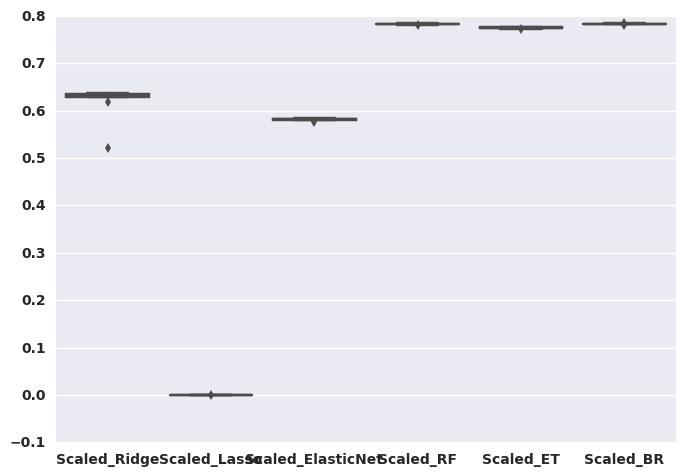

In [54]:
## May take a long time (hours)
mods = [      ("Scaled_Ridge", Pipeline([("Scaler", StandardScaler()), \
                                ("Ridge", Ridge(random_state=5))])), \
              ("Scaled_Lasso", Pipeline([("Scaler", StandardScaler()), \
                                ("Lasso", Lasso(random_state=5))])), \
              ("Scaled_ElasticNet", Pipeline([("Scaler", StandardScaler()), \
                                ("ElasticNet", ElasticNet(alpha=0.1, l1_ratio=0.7))])),\
              #("Scaled_SVR",   Pipeline([("Scaler", StandardScaler()),\
              #                  ("svr", SVR(kernel='rbf'))])),\
              ("Scaled_RF",    Pipeline([("Scaler", StandardScaler()),\
                                ("RF", RandomForestRegressor(random_state=5))])),\
              ("Scaled_ET",    Pipeline([("Scaler", StandardScaler()),\
                                ("ET", ExtraTreesRegressor(random_state=5))])),\
              ("Scaled_BR",    Pipeline([("Scaler", StandardScaler()),\
                                ("BR", BaggingRegressor(random_state=5))])) ]
res, names = [ ], [ ]
for name, mod in mods:
    kf = KFold(n_splits=10, shuffle=True, random_state=5)
    cv_res = cross_val_score(mod, X_train, y_train, cv=kf, scoring='r2', n_jobs=1)
    names.append(name)
    res.append(cv_res)
    print("%s: %f +/- %f" % (name, cv_res.mean(), cv_res.std()))
sns.boxplot(pd.DataFrame(np.array(res).T, columns = names))
plt.show()

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


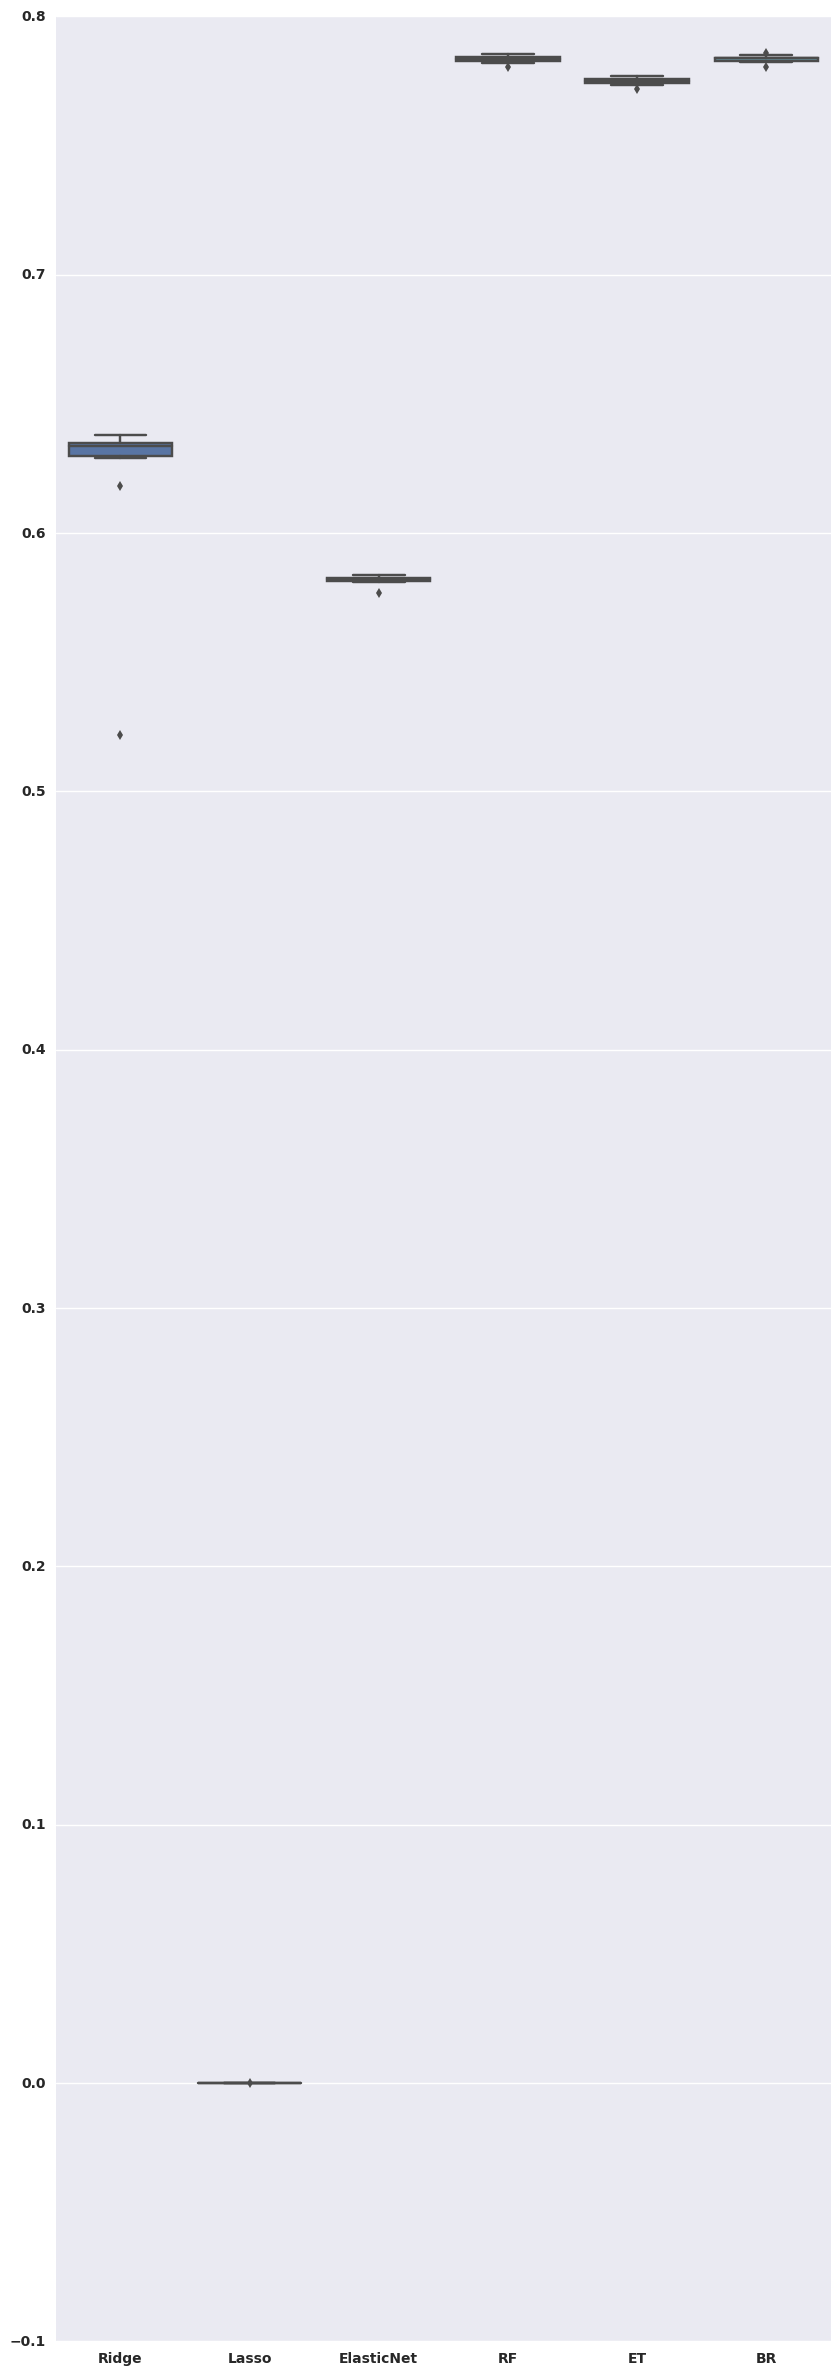

In [83]:
plt.figure(figsize = (10,30))
sns.boxplot(pd.DataFrame(np.array(res).T, columns = ['Ridge', 'Lasso', 'ElasticNet', 'RF', 'ET', 'BR']))
plt.show()

Except Lasso which has a low R-squared (near 0), other five regressors seem to perform better, all having R-squared scores more than 0.58.

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


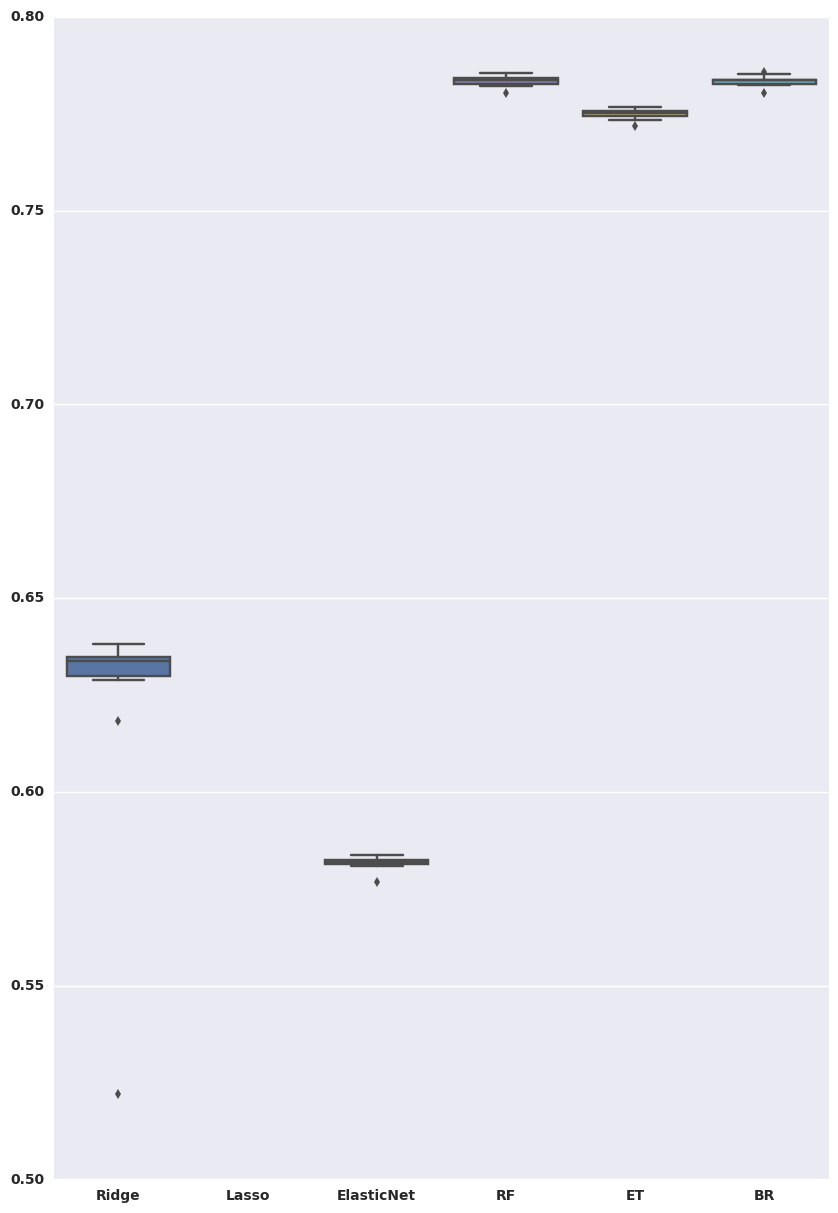

In [85]:
plt.figure(figsize = (10,15))
plt.ylim(0.5, 0.8)
sns.boxplot(pd.DataFrame(np.array(res).T, columns = ['Ridge', 'Lasso', 'ElasticNet', 'RF', 'ET', 'BR']))
plt.show()

### Saving parameters
mods = [          ("Scaled_RF",    Pipeline([("Scaler", StandardScaler()),\
                                ("RF", RandomForestRegressor(random_state=5))]))]
res, names = [ ], [ ]
for name, mod in mods:
    kf = KFold(n_splits=10, shuffle=True, random_state=5)
    cv_res = cross_val_score(mod, X_train, y_train, cv=kf, scoring='r2', n_jobs=1)
    names.append(name)
    res.append(cv_res)
    print("%s: %f +/- %f" % (name, cv_res.mean(), cv_res.std()))
sns.boxplot(pd.DataFrame(np.array(res).T, columns = names))
plt.show()

res =
[array([ 0.7835834 ,  0.78428975,  0.7820334 ,  0.7802487 ,  0.78387665,
         0.78249873,  0.78551571,  0.78529915,  0.78369249,  0.78318177])]

name = 'Scaled_RF'

mod =
Pipeline(steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RF', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=5,
           verbose=0, warm_start=False))])

In [ ]:
scaled_RF = mods[3][1]

In [33]:
# choose a good RandomForest model to test. May take hours.
param_grid_rf = [{'RF__n_estimators':[50],
                 'RF__max_depth': np.arange(5,15,2),
                 'RF__min_samples_leaf':[0.04] } ]
grid_rf = GridSearchCV(estimator=scaled_RF, param_grid=param_grid_rf,
                      scoring='neg_mean_squared_error',
                      cv = KFold(n_splits=3, random_state=5, shuffle=True),
                      verbose=1)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_score_, grid_rf.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 133.6min finished


-0.0754241873365 {'RF__max_depth': 7, 'RF__min_samples_leaf': 0.04, 'RF__n_estimators': 50}


RMSE is:  0.274059661824


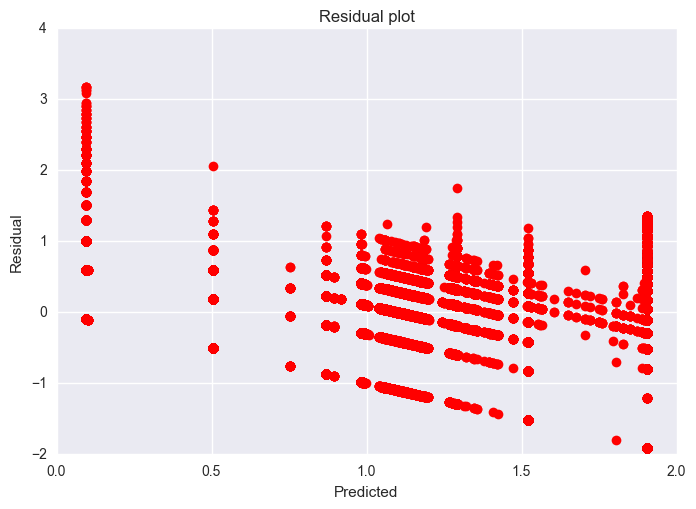

In [35]:
## residual plot
matplotlib.rcParams['agg.path.chunksize'] = 10000

y_pred = grid_rf.predict(X_test)
rmse = np.sqrt(sum((y_pred-y_test)**2)/len(y_pred))
print('RMSE is: ', rmse)

# save predict to csv file
towt = pd.concat([X_test, pd.DataFrame(y_test), pd.DataFrame(y_pred)], axis=1)
towt.to_csv('scaled_RF_predicted.csv')

plt.plot(y_pred, y_test - y_pred, 'ro')
plt.title('Residual plot')
plt.ylabel('Residual')
plt.xlabel('Predicted')
plt.show()